In [1]:
%matplotlib inline
from sklearn.ensemble import RandomForestClassifier
from sklearn.manifold import TSNE
from neo4j import GraphDatabase
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, f1_score
import numpy as np

sns.set(font_scale = 1.5)

In [2]:
# Connect to Neo4j
driver = GraphDatabase.driver('bolt://localhost:7687', auth=('neo4j', 'letmein'))

def read_query(query):
    with driver.session() as session:
        result = session.run(query)
        return pd.DataFrame([r.values() for r in result], columns=result.keys())

# Exploring languages

In [3]:
read_query("""
MATCH (s:Stream)
WHERE size((s)-[:HAS_LANGUAGE]->()) > 1
RETURN s.name
""")

,s.name
0,gige


Just a single streamer with two languages, so we can just ignore multi-language streams

In [4]:
read_query("""
MATCH (l:Language)
RETURN l.name as language,
       size((l)<--()) as number_of_streams
""")

,language,number_of_streams
0,en,1867
1,ja,77
2,en-gb,176
3,fr,276
4,it,146
5,ko,266
6,ru,280
7,es,347
8,de,303
9,zh-tw,112


In [5]:
# Define a threshold of at least 100 streamers
read_query("""
MATCH (l:Language)
WHERE size((l)<--()) > 100
RETURN l.name
""")

,l.name
0,en
1,en-gb
2,fr
3,it
4,ko
5,ru
6,es
7,de
8,zh-tw
9,pt-br


In [6]:
# Tag streamers with other languages so that they will be ignored in the analysis
read_query("""
MATCH (l:Language)
WHERE size((l)<--()) < 100
MATCH (l)<--(streamer)
SET streamer:Exclude
RETURN distinct 'success' as result
""")

,result
0,success


# Exploring chatter network for bots etc..

In [7]:
# Exclude users with a single chatter/vip/mod relationship
read_query("""CALL apoc.periodic.iterate("
    MATCH (u:User)
    WHERE size((u)-->(:Stream)) = 1
    RETURN u",
    "SET u:Exclude",
    {batchSize:50000, parallel:true}
)""")

,batches,total,timeTaken,committedOperations,failedOperations,failedBatches,retries,errorMessages,batch,operations,wasTerminated,failedParams,updateStatistics
0,9,406322,13,406322,0,0,0,{},"{'total': 9, 'committed': 9, 'failed': 0, 'err...","{'total': 406322, 'committed': 406322, 'failed...",False,{},"{'nodesDeleted': 0, 'labelsAdded': 0, 'relatio..."


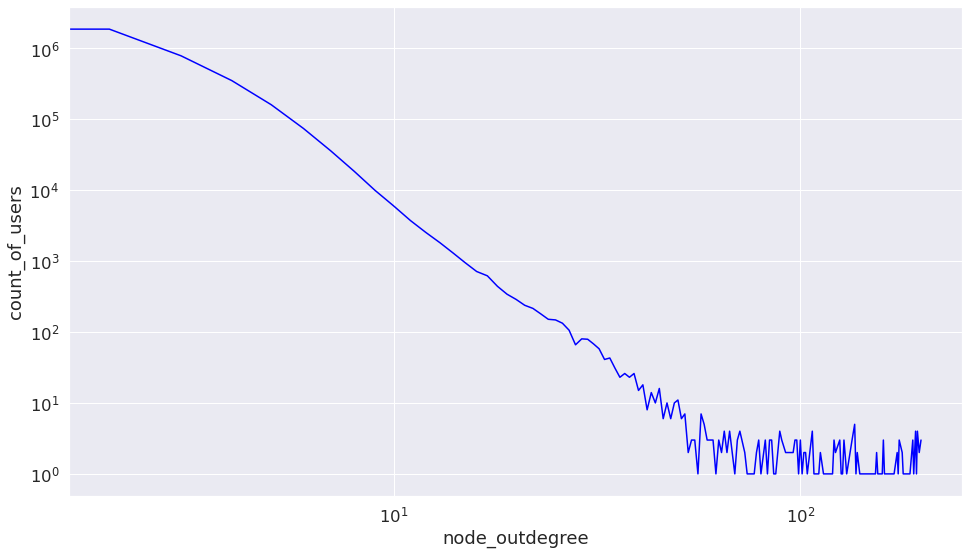

In [8]:
data = read_query("""
MATCH (u:User)
WHERE NOT u:Exclude
WITH u, size((u)-[:CHATTER|VIP|MODERATOR]->()) as node_outdegree
RETURN node_outdegree, count(*) as count_of_users
ORDER BY node_outdegree ASC""")

fig, ax = plt.subplots(figsize=(16,9))
ax = sns.lineplot(x="node_outdegree", y="count_of_users", data=data, color="blue")
ax.set_yscale("log")
ax.set_xscale("log")


In [9]:
read_query("""
MATCH (u:User)
WHERE NOT u:Exclude
WITH u, size((u)-[:CHATTER|VIP|MODERATOR]->()) as node_outdegree
WHERE node_outdegree > 200
RETURN u.name as user, node_outdegree
ORDER BY node_outdegree DESC
""")

,user,node_outdegree


In [10]:
# I decided to exclude users who have chatted in more than 200 channels... even that seems a lot
read_query("""
MATCH (u:User)
WHERE NOT u:Exclude
WITH u, size((u)-[:CHATTER|VIP|MODERATOR]->()) as node_outdegree
WHERE node_outdegree > 200
SET u:Exclude
""")

""


In [11]:
# Just check moderators for some additional bots
read_query("""
MATCH (u:User)
WHERE NOT u:Exclude
RETURN u.name as user, size((u)-[:MODERATOR]->()) as mod_count
ORDER BY mod_count DESC LIMIT 50
""")

,user,mod_count
0,etozhebot,10
1,crtvly,10
2,songlistbot,10
3,spaniel,9
4,bu1zer,9
5,iandy88,9
6,x_samix_x,9
7,supibot,9
8,logicalsolutions,8
9,datenschutz,8


In [12]:
# Exclude users who moderate more than 10 channels
read_query("""
MATCH (u:User)
WHERE NOT u:Exclude
WITH u, size((u)-[:MODERATOR]->()) as mod_count
WHERE mod_count > 10
SET u:Exclude
RETURN distinct 'success' as result
""")

,result


# Train - test split

In [13]:
read_query("""
MATCH (l:Language)<-[:HAS_LANGUAGE]-(s:Stream)
WHERE NOT s:Exclude
RETURN l.name as language, count(*)
""")

,language,count(*)
0,en,1659
1,en-gb,157
2,fr,244
3,it,137
4,ko,238
5,ru,244
6,es,300
7,de,272
8,zh-tw,102
9,pt-br,181


In [14]:
# We will treat "en" and "en-gb" as the same

In [15]:
read_query("""
MATCH (s:Stream)-[:HAS_LANGUAGE]->(l:Language)
WHERE NOT s:Exclude
SET s.language = CASE WHEN l.name = 'en-gb' THEN 'en' ELSE l.name END
""")

""


In [16]:
read_query("""
MATCH (s:Stream)
WHERE NOT s:Exclude
WITH s.language as language, s
// add ordering for complete reproducability
ORDER BY s.name
WITH language, count(*) as count, collect(s) as streamers
WITH language, streamers, toInteger(count * 0.8) as training_size
UNWIND streamers[..training_size] as train_data
SET train_data:Train
""")

""


In [17]:
#Double check
read_query("""
MATCH (t:Train)
RETURN t.language as language, count(*) as training_size
""")

,language,training_size
0,en,1452
1,ko,190
2,de,217
3,zh-tw,81
4,ru,195
5,fr,195
6,es,240
7,tr,88
8,it,109
9,pt-br,144


# Infer co-chatter network

Project the graph

In [18]:
read_query("""
CALL gds.graph.create.cypher("twitch",
"MATCH (u:User) WHERE NOT u:Exclude RETURN id(u) as id, labels(u) as labels, coalesce(u.followers,0) as followers, coalesce(u.total_view_count,0) as total_view_count",
"MATCH (s:User)-->(t:Stream)
 WHERE NOT s:Exclude AND NOT t:Exclude
 RETURN id(t) as source, id(s) as target",
{validateRelationships:false})
""")

,nodeQuery,relationshipQuery,graphName,nodeCount,relationshipCount,createMillis
0,MATCH (u:User) WHERE NOT u:Exclude RETURN id(u...,MATCH (s:User)-->(t:Stream)\n WHERE NOT s:Excl...,twitch,4271897,7647926,19017


Node similarity

In [19]:
read_query("""
CALL gds.nodeSimilarity.stats("twitch")
""")['similarityDistribution'].to_list()

[{'p1': 0.0005675404972862452,
  'max': 1.0000076293654274,
  'p5': 0.002954214782221243,
  'p90': 0.058524370164377615,
  'p50': 0.014385879010660574,
  'p95': 0.08700561520527117,
  'p10': 0.004273533792002127,
  'p75': 0.030665039987070486,
  'p99': 0.189642906159861,
  'p25': 0.007166147202951834,
  'p100': 1.0000076293654274,
  'min': 5.443114787340164e-06,
  'mean': 0.02655834522612726,
  'stdDev': 0.040834074257494656}]

In [20]:
read_query("""
CALL gds.nodeSimilarity.mutate("twitch", 
  {topK:25, mutateProperty:'score', mutateRelationshipType:'SHARED_AUDIENCE'})

""")

,createMillis,computeMillis,mutateMillis,postProcessingMillis,nodesCompared,relationshipsWritten,similarityDistribution,configuration
0,2,45452,143,-1,3629,89079,"{'p1': 0.0003196932084392756, 'max': 1.0000076...","{'topK': 25, 'bottomK': 10, 'bottomN': 0, 'rel..."


# Evaluate classifier

In [21]:
def evaluate(y_true,y_pred):
  labels = set(y_true)
  print("Overall f1 score: {}".format(f1_score(y_true, 
               y_pred, average="micro")))
  print(classification_report(y_true,y_pred))
  cm = confusion_matrix(y_true,y_pred)
  cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
  cmat = pd.DataFrame(cm)
  cmat.columns = labels
  fig, ax = plt.subplots(figsize=(16,9))
  #cmat.set_index([pd.Index(labels, '')],inplace=True)
  ax = sns.heatmap(cmat,cmap="YlGnBu", annot=True)
  plt.title("Confusion Matrix")

Overall f1 score: 0.8692098092643052
              precision    recall  f1-score   support

           0       0.83      0.93      0.88       364
           1       1.00      0.81      0.90        48
           2       0.88      0.80      0.84        55
           3       0.95      1.00      0.98        21
           4       0.86      0.76      0.80        49
           5       0.93      0.88      0.91        49
           6       0.94      0.85      0.89        60
           7       0.83      0.83      0.83        23
           8       0.91      0.71      0.80        28
           9       0.90      0.73      0.81        37

    accuracy                           0.87       734
   macro avg       0.90      0.83      0.86       734
weighted avg       0.87      0.87      0.87       734



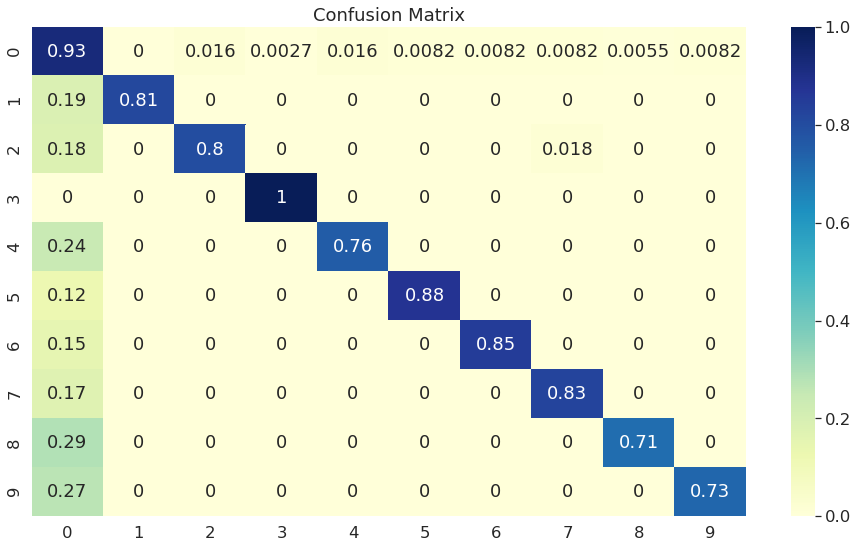

In [22]:
embeddings = read_query("""
CALL gds.fastRP.stream(
  "twitch",
  {nodeLabels:['Stream'], relationshipTypes:['SHARED_AUDIENCE'],
   relationshipWeightProperty:'score', embeddingDimension: 256}
) YIELD nodeId, embedding
WITH gds.util.asNode(nodeId) as node, nodeId, embedding
RETURN nodeId, embedding, node.language as language, CASE WHEN node:Train then 'train' else 'test' END as split
""")

embeddings['output'] = pd.factorize(embeddings['language'])[0]
train_data = embeddings[embeddings['split'] == 'train']
test_data = embeddings[embeddings['split'] == 'test']
rf_classifier = RandomForestClassifier()
rf_classifier.fit(train_data['embedding'].to_list(), train_data['output'].to_list())
rf_predictions = rf_classifier.predict(test_data['embedding'].to_list())
evaluate(test_data['output'].to_list(), rf_predictions)

Overall f1 score: 0.8923705722070845
              precision    recall  f1-score   support

           0       0.87      0.92      0.90       364
           1       0.97      0.81      0.89        48
           2       0.92      0.85      0.89        55
           3       0.95      1.00      0.98        21
           4       0.87      0.80      0.83        49
           5       0.94      0.92      0.93        49
           6       0.92      0.95      0.93        60
           7       0.76      0.83      0.79        23
           8       0.92      0.82      0.87        28
           9       0.91      0.84      0.87        37

    accuracy                           0.89       734
   macro avg       0.90      0.87      0.89       734
weighted avg       0.89      0.89      0.89       734



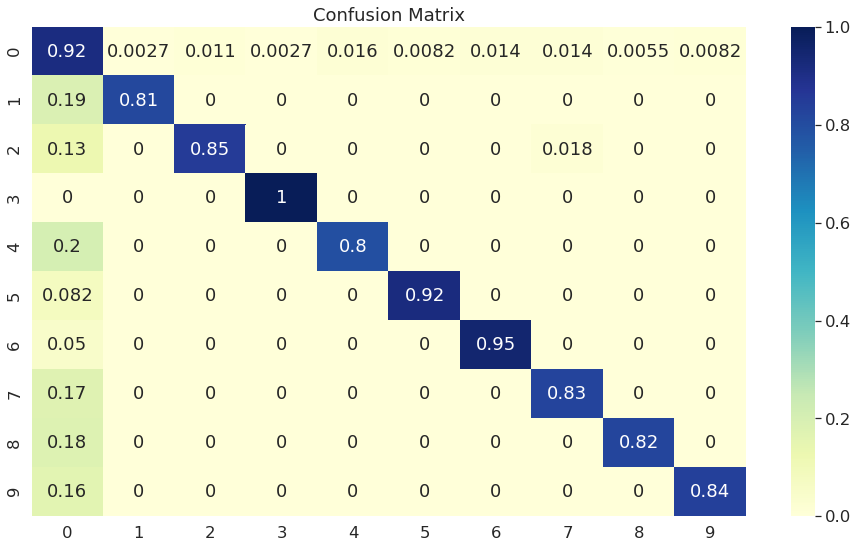

In [23]:
embeddings = read_query("""
CALL gds.fastRP.stream(
  "twitch",
  {nodeLabels:['Stream'], relationshipTypes:['SHARED_AUDIENCE'], embeddingDimension: 256}
) YIELD nodeId, embedding
WITH gds.util.asNode(nodeId) as node, nodeId, embedding
RETURN nodeId, embedding, node.language as language, CASE WHEN node:Train then 'train' else 'test' END as split
""")

embeddings['output'] = pd.factorize(embeddings['language'])[0]
train_data = embeddings[embeddings['split'] == 'train']
test_data = embeddings[embeddings['split'] == 'test']
rf_classifier = RandomForestClassifier()
rf_classifier.fit(train_data['embedding'].to_list(), train_data['output'].to_list())
rf_predictions = rf_classifier.predict(test_data['embedding'].to_list())
evaluate(test_data['output'].to_list(), rf_predictions)

Overall f1 score: 0.8991825613079019
              precision    recall  f1-score   support

           0       0.89      0.92      0.90       364
           1       0.98      0.85      0.91        48
           2       0.94      0.85      0.90        55
           3       0.95      1.00      0.98        21
           4       0.85      0.82      0.83        49
           5       0.91      0.88      0.90        49
           6       0.92      0.97      0.94        60
           7       0.80      0.87      0.83        23
           8       0.92      0.86      0.89        28
           9       0.91      0.86      0.89        37

    accuracy                           0.90       734
   macro avg       0.91      0.89      0.90       734
weighted avg       0.90      0.90      0.90       734



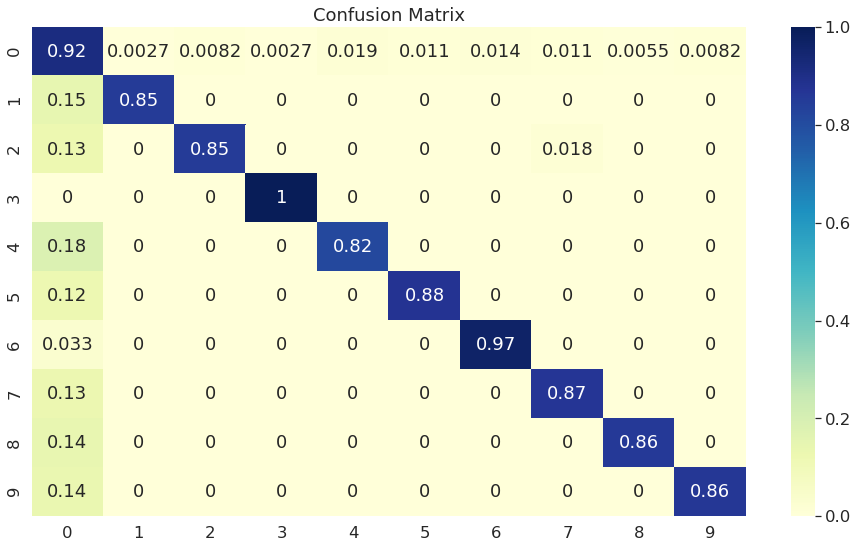

In [24]:
embeddings = read_query("""
CALL gds.beta.fastRPExtended.stream(
  "twitch",
  {nodeLabels:['Stream'], relationshipTypes:['SHARED_AUDIENCE'],
   embeddingDimension: 256, featureProperties: ['followers','total_view_count']}
) YIELD nodeId, embedding
WITH gds.util.asNode(nodeId) as node, nodeId, embedding
RETURN nodeId, embedding, node.language as language, CASE WHEN node:Train then 'train' else 'test' END as split
""")

embeddings['output'] = pd.factorize(embeddings['language'])[0]
train_data = embeddings[embeddings['split'] == 'train']
test_data = embeddings[embeddings['split'] == 'test']
rf_classifier = RandomForestClassifier()
rf_classifier.fit(train_data['embedding'].to_list(), train_data['output'].to_list())
rf_predictions = rf_classifier.predict(test_data['embedding'].to_list())
evaluate(test_data['output'].to_list(), rf_predictions)

Overall f1 score: 0.8978201634877384
              precision    recall  f1-score   support

           0       0.89      0.91      0.90       364
           1       0.98      0.85      0.91        48
           2       0.92      0.85      0.89        55
           3       0.95      1.00      0.98        21
           4       0.86      0.86      0.86        49
           5       0.91      0.88      0.90        49
           6       0.92      0.98      0.95        60
           7       0.75      0.78      0.77        23
           8       0.92      0.86      0.89        28
           9       0.91      0.86      0.89        37

    accuracy                           0.90       734
   macro avg       0.90      0.88      0.89       734
weighted avg       0.90      0.90      0.90       734



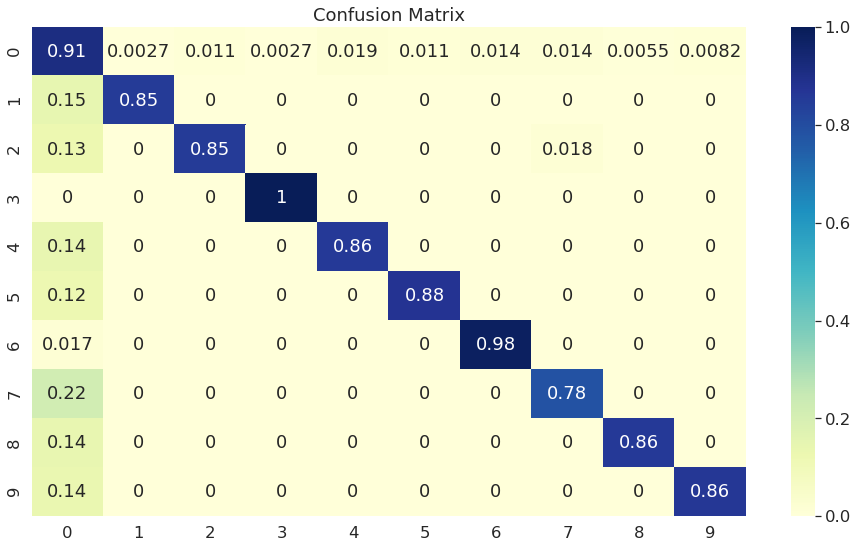

In [25]:
embeddings = read_query("""
CALL gds.beta.fastRPExtended.stream(
  "twitch",
  {nodeLabels:['Stream'], relationshipTypes:['SHARED_AUDIENCE'],
   embeddingDimension: 256, featureProperties: ['followers','total_view_count'],
   iterationWeights:[0.1, 0.5, 0.9, 1.0, 1.0]}
) YIELD nodeId, embedding
WITH gds.util.asNode(nodeId) as node, nodeId, embedding
RETURN nodeId, embedding, node.language as language, CASE WHEN node:Train then 'train' else 'test' END as split
""")

embeddings['output'] = pd.factorize(embeddings['language'])[0]
train_data = embeddings[embeddings['split'] == 'train']
test_data = embeddings[embeddings['split'] == 'test']
rf_classifier = RandomForestClassifier()
rf_classifier.fit(train_data['embedding'].to_list(), train_data['output'].to_list())
rf_predictions = rf_classifier.predict(test_data['embedding'].to_list())
evaluate(test_data['output'].to_list(), rf_predictions)

In [26]:
from sklearn.manifold import TSNE

In [27]:
tsne = TSNE(n_components=2, n_iter=300)
tsne_results = tsne.fit_transform(embeddings['embedding'].to_list())

In [28]:
embeddings['tsne_x'] = [x[0] for x in list(tsne_results)]
embeddings['tsne_y'] = [x[1] for x in list(tsne_results)]

<AxesSubplot:xlabel='tsne_x', ylabel='tsne_y'>

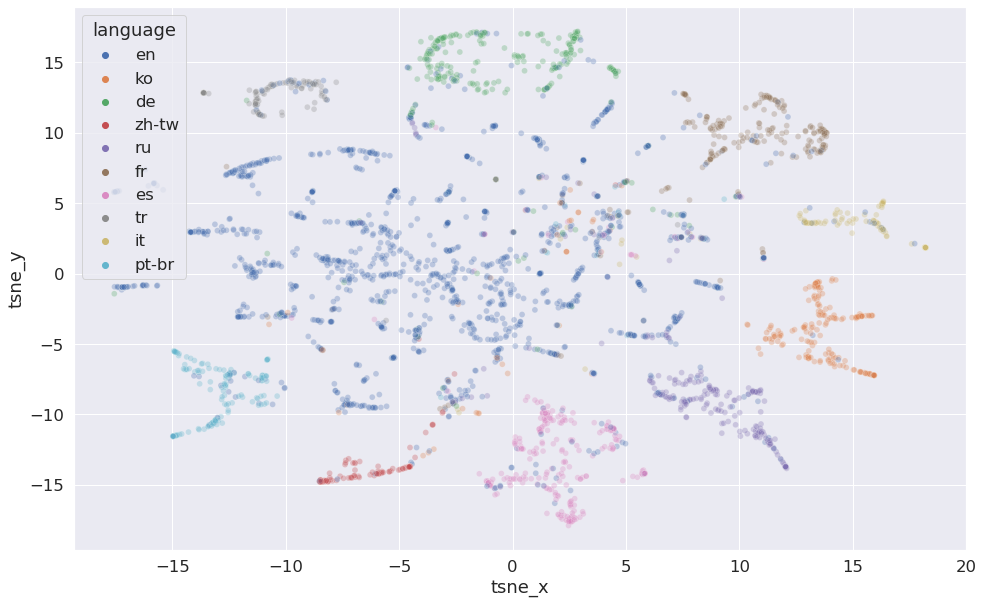

In [29]:
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne_x", y="tsne_y",
    hue="language",
    #palette=sns.color_palette("hls", 10),
    data=embeddings,
    legend="full",
    alpha=0.3
)